In [27]:
import pandas as pd
import matplotlib.pyplot as plt


In [28]:
# Later we will important the cleaned dataset
# BA for Beer Advocate datasets
# RB for Rate Beer datasets
# need to convert the review and rating txt as csv

# Importation of dataset
beers_BA_df = pd.read_csv('../Dataset/BeerAdvocate/beers.csv')
beers_RB_df = pd.read_csv('../Dataset/RateBeer/beers.csv')
users_BA_df = pd.read_csv('../Dataset/BeerAdvocate/users.csv')
users_RB_df = pd.read_csv('../Dataset/RateBeer/users.csv')




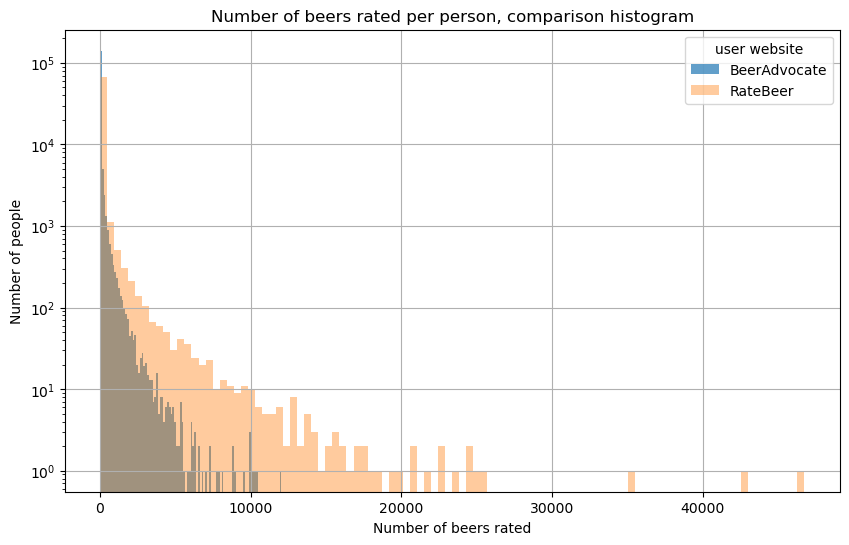

In [29]:
# Plotting number of ratings made per user in an histogram

plt.figure(figsize=(10, 6))

users_BA_df['nbr_ratings'].hist(bins=100, log=True, alpha=0.7, label='BeerAdvocate')
users_RB_df['nbr_ratings'].hist(bins=100,log=True, alpha=0.4, label='RateBeer')

plt.xlabel("Number of beers rated")
plt.ylabel("Number of people")
plt.legend(title='user website')
plt.title('Number of beers rated per person, comparison histogram')
plt.show()

RateBeer have only about 20-30 users with more than 12'000 ratings
BeerAdvocate have only abouth 20-30 users above 5'000

Now is time to define class on users related to how many ratings they did.
- Novice are users with only a few ratings, let's say 1-20.
- Enthusiasts are users with moderate number of ratings, let's say 21-100
- Connoisseur are users with high number of ratings, let's say 101+

It is important to note that this choice is arbitrary. It could me made differently or could be interactive for the reader of the story to label the users differently according to how many ratings he thinks is enough to be a connoisseur/enthusiasts/novice.

Another important things to take into account is that these classes do not represent users as novice or connoisseur about **beers**, but about **rating** on this particular website.

Let's classify now the users in the three mentioned categories.



In [36]:
def classify_user_rating_level(user_df, novice_level=20, enthusiasts_level=100):
    
    def __classify(nbr_ratings):
        if nbr_ratings <= novice_level:
            return 'novice'
        elif nbr_ratings <= enthusiasts_level:
            return 'enthusiast'
        else:
            return 'connoisseur'
        
    user_df['rating_user_level'] = user_df['nbr_ratings'].apply(__classify)

    return user_df
    

In [42]:
users_classified_BA = classify_user_rating_level(users_BA_df)
users_classified_RB = classify_user_rating_level(users_RB_df)
print("Number of people per class BA dataset", users_classified_BA['rating_user_level'].value_counts())
print("Number of people per class RB dataset", users_classified_RB['rating_user_level'].value_counts())

Number of people per class BA dataset rating_user_level
novice         119819
enthusiast      19498
connoisseur     14387
Name: count, dtype: int64
Number of people per class RB dataset rating_user_level
novice         57937
connoisseur     6390
enthusiast      5847
Name: count, dtype: int64


As we can see, if we want to do further analysis using the three classes of users, we will need to either rebalance the datasets, weight the analysis, or...

Furthermore, we could try to aggregate people who rated on both sites ?

In [46]:
users_classified_RB.sample(3)


,nbr_ratings,user_id,user_name,joined,location,rating_user_level
39244,3,344048,curnutmj1014,1.415617e+09,"United States, Ohio",novice
28360,5,393360,CervezaMe,1.449400e+09,Australia,novice
27053,88,41004,drawde,1.155377e+09,"United States, California",enthusiast
